In [9]:
import datetime, os
import numpy as np
import cv2, skimage
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.measure import find_contours

print((tf.config.list_physical_devices('GPU')))



[]


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


ModuleNotFoundError: No module named 'tensorflow'

In [9]:
%ls ../input/heart-slices-dataset
%cd pwd

ls: cannot access '../input/heart-slices-dataset': No such file or directory
[Errno 2] No such file or directory: 'pwd'
/root


In [10]:
#Loading the data

Data_1 = np.load('/kaggle/input/heart-slices-dataset/Data.npy')

"""Data_2 = np.load('Data2.npy')

Data= np.concatenate((Data_1,Data_2),0)"""

"Data_2 = np.load('Data2.npy')\n\nData= np.concatenate((Data_1,Data_2),0)"

In [11]:
%cd /kaggle/working/
%ls

/kaggle/working


X_train shape (649, 224, 224, 3)
X_train shape (73, 224, 224, 3)
y_train (649, 224, 224, 4)
y_test (73, 224, 224, 4)
1.0000000298023224


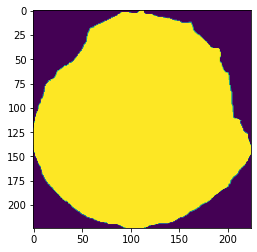

In [12]:
# Train/test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split((Data_1[:,:,:,:3]/127.5)-1, Data_1[:,:,:,3:]/255, test_size = 0.1, random_state = 42)
print('X_train shape', X_train.shape)
print('X_train shape', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print(np.max(y_test))
plt.imshow(y_test[0,:,:,0])

In [39]:
# Create a datasets from the NumPy arrays
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Create mini-batches of the datasets
batch_size = 32
training_dataset = training_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [55]:
del X_train, y_train
print("Original datasets are deleted")

Original datasets are deleted


In [7]:
def double_conv_block(x, n_filters):
  #Conv2D then ReLU activation
  x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer = "glorot_normal")(x)
  #Conv2D then ReLU activation
  x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer = "glorot_normal")(x)
  return x

def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = tf.keras.layers.MaxPool2D(2)(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

def upsample_block(x, conv_features, n_filters):
  #upsample
  x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  #concatenate 
  x = tf.keras.layers.concatenate([x, conv_features])
  #dropout
  x = tf.keras.layers.Dropout(0.3)(x)
  #Conv2D twice with leaky ReLU activation
  x = double_conv_block(x, n_filters)

  return x

def build_unet_model():

    # inputs
    inputs = tf.keras.Input(shape=(224,224,3))

    # contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 16)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 32)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 64)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 128)

    # 5 middle convolution
    bottleneck = double_conv_block(p4, 256)

    # expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 128)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 64)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 32)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 16)

    # outputs
    outputs = tf.keras.layers.Conv2D(4, 1, padding="same", activation="sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [61]:
model = build_unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics='categorical_accuracy')

In [62]:
number_of_epochs = 10

train_length = len(training_dataset) #number train samples
batch_size=32
steps_per_epoch = train_length //  32       #integer resulting division

test_length = len(X_test) #number of test samples
validation_steps = test_length //  32       #batch_size        #must not be higer than the actual test lenght becasue we run out of data

model_history = model.fit(training_dataset,
                          epochs=number_of_epochs,
                          validation_data=test_dataset)

#look for the lables if they truly have binary values: yeah they only have 0-1
#set batch size to the x size: working to an extent but loss still blows up

# Save the model
model.save('model', save_format='h5')

Epoch 1/10
21/21 [==============================] - 7s 258ms/step - loss: 0.4524 - categorical_accuracy: 0.9412 - val_loss: 0.2830 - val_categorical_accuracy: 0.9986
Epoch 2/10
21/21 [==============================] - 5s 246ms/step - loss: 0.2595 - categorical_accuracy: 0.8852 - val_loss: 0.2224 - val_categorical_accuracy: 0.9340
Epoch 3/10
21/21 [==============================] - 5s 237ms/step - loss: 0.1817 - categorical_accuracy: 0.9616 - val_loss: 0.1610 - val_categorical_accuracy: 0.9776
Epoch 4/10
21/21 [==============================] - 5s 240ms/step - loss: 0.1546 - categorical_accuracy: 0.9735 - val_loss: 0.1483 - val_categorical_accuracy: 0.9812
Epoch 5/10
21/21 [==============================] - 5s 246ms/step - loss: 0.1448 - categorical_accuracy: 0.8999 - val_loss: 0.1479 - val_categorical_accuracy: 0.8745
Epoch 6/10
21/21 [==============================] - 5s 236ms/step - loss: 0.1393 - categorical_accuracy: 0.9164 - val_loss: 0.1469 - val_categorical_accuracy: 0.9953
Epoc

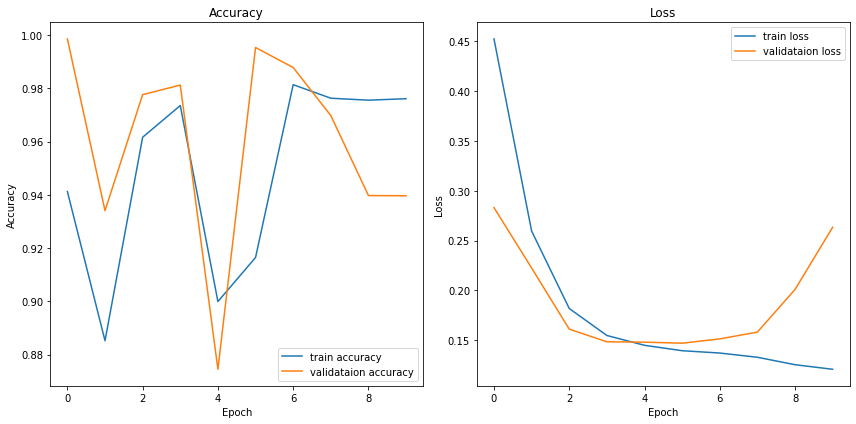

In [63]:
def display_learning_curves(history):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(number_of_epochs)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.savefig('curves.png')
    plt.show()
    
# Display learning curves 
display_learning_curves(model.history)

In [29]:
def calculate_iou(model, test_dataset, num_iterations):
    # Initialize a list to store the IOU values for each iteration
    iou_values = []

    # Loop over the iterations
    for i in range(num_iterations):
        # Get the next batch of data from the test dataset
        test_batch = test_dataset.next()

        # Get the predictions and labels from the test batch
        predictions = model(test_batch['input'])
        labels = test_batch['output']

        # Calculate the IOU for the current iteration
        iou = tf.keras.metrics.MeanIoU(num_classes=num_classes).update_state(labels, predictions)

        # Append the IOU value to the list
        iou_values.append(iou.numpy())
    
    # Plot the IOU values over the iterations
    plt.plot(range(num_iterations), iou_values)
    plt.xlabel('Iteration')
    plt.ylabel('IOU')
    plt.show()
    
calculate_iou(model, test_dataset=X_test, num_iterations=number_of_epochs)

AttributeError: 'numpy.ndarray' object has no attribute 'next'

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(display_list[i], cmap='gray')
    else:
      plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

# This returns 1 for the maximum element in the classes for each pixel(most probable)
def create_mask(pred_mask):
  #print('Before argmax: \n', pred_mask)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #print('After argmax: \n', pred_mask)
  pred_mask = pred_mask[..., tf.newaxis]
  #print('After newaxis: \n',pred_mask)
  return pred_mask

def show_predictions(X_test, y_test, predicted_images, reconstructed_model):
    pred_mask = reconstructed_model.predict(image)
    display([X_test[0,:,:,:], y_test[0], create_mask(pred_mask)[0]])

In [13]:
reconstructed_model = tf.keras.models.load_model('model')

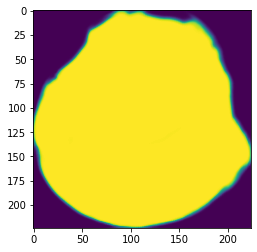

In [14]:
predicted_masks = model.predict(X_test)
first_mask = predicted_masks[0]
plt.imshow(predicted_masks[0,:,:,0])

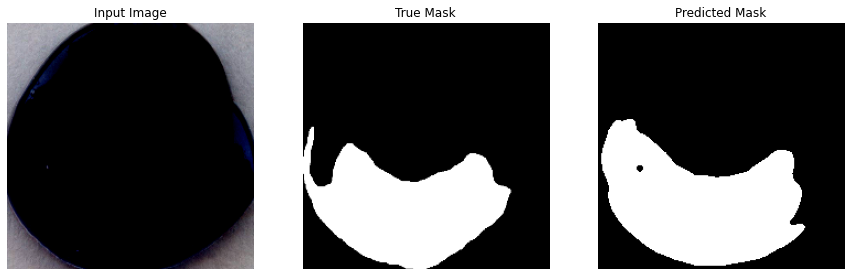

In [15]:
# Turning high probability predictions into a real binary mask
ret, pred_bin = cv2.threshold(first_mask[..., 3], 0.95, 1 , cv2.THRESH_BINARY)
#display([X_test[0,:,:,:], y_test[0,:,:], first_mask[..., 0]])
display([X_test[0,:,:,:], y_test[0,:,:,3], pred_bin])